In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDRegressor
from sklearn.impute import SimpleImputer

In [2]:
datafile = "household_power_consumption.csv"
df = pd.read_csv(datafile, sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt') # Исправленный разделитель

#infer_datetime_format по умолчанию false. Pandas попытается определить формат строк даты и переключится на более быстрый метод их анализа
#low_memory=False. Установка этого флага может помочь избежать предупреждения о смешанных типах данных
# na_values = '?' означает, что данные содержат пропущенные значения, обозначенные символом ?.
# index_col - дата и время - это индекс

# Проверка изменений
print(df)

C:\Users\Ktulh\AppData\Local\Temp\ipykernel_14996\1518227159.py:2: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(datafile, sep=';',
C:\Users\Ktulh\AppData\Local\Temp\ipykernel_14996\1518227159.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(datafile, sep=';',


                     Global_active_power  Global_reactive_power  Voltage  \
dt                                                                         
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   
...                                  ...                    ...      ...   
2008-12-13 21:34:00                0.426                  0.076   242.27   
2008-12-13 21:35:00                0.424                  0.076   242.10   
2008-12-13 21:36:00                0.422                  0.076   241.73   
2008-12-13 21:37:00                0.422                  0.078   242.56   
2008-12-13 21:38:00                0.422                  0.078   242.61   

           

C:\Users\Ktulh\AppData\Local\Temp\ipykernel_14996\1518227159.py:2: UserWarning: Parsing dates in %d.%m.%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(datafile, sep=';',


Необходимо определить, какой параметр подходит для предсказания, поэтому необходимо построить корреляционную матрицу:

In [3]:

correlation_matrix = df.corr()
print(correlation_matrix)



                       Global_active_power  Global_reactive_power   Voltage  \
Global_active_power               1.000000               0.254841 -0.400987   
Global_reactive_power             0.254841               1.000000 -0.120617   
Voltage                          -0.400987              -0.120617  1.000000   
Global_intensity                  0.999020               0.271843 -0.411298   
Sub_metering_1                    0.474129               0.137682 -0.203805   
Sub_metering_2                    0.456677               0.150528 -0.178899   
Sub_metering_3                    0.624107               0.076274 -0.284932   

                       Global_intensity  Sub_metering_1  Sub_metering_2  \
Global_active_power            0.999020        0.474129        0.456677   
Global_reactive_power          0.271843        0.137682        0.150528   
Voltage                       -0.411298       -0.203805       -0.178899   
Global_intensity               1.000000        0.478198        0.46

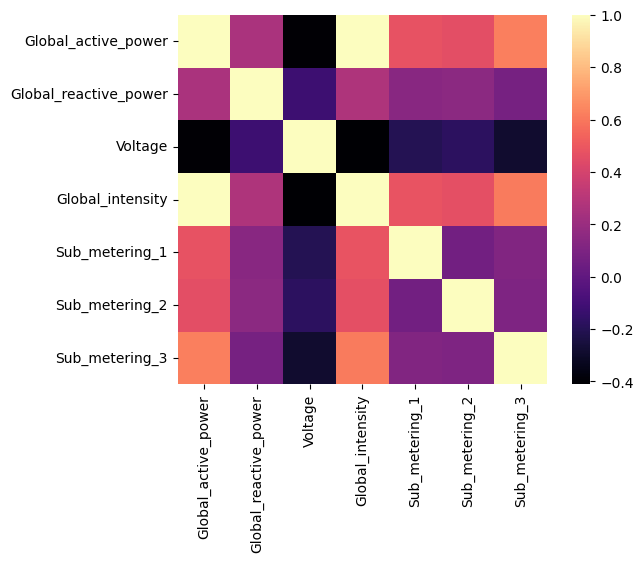

In [4]:
corrmat = df.corr()                             # Вычисление матрицы корреляции (зависимости одной переменной от другой)
sns.heatmap(corrmat, cmap='magma', square=True) # Построение тепловой карты с использованием seaborn, используя матрицу корреляции corrmat,
plt.show()

Корреляция — ключевой термин в сфере анализа данных, который описывает
степень связи между переменными и позволяет понять, как одна величина 
изменяется при изменении другой.

Теперь необходимо определить, какой столбец имеет наибольщую линейную
зависимость с бОльшим количеством параметров


In [5]:
column_to_predict = corrmat.columns[0]  # Инициализация значением первой колонки из списка имен колонок в матрице корреляции

for column in corrmat.columns:          # Начало цикла по всем колонкам матрицы корреляции
    if corrmat[column].sum() > corrmat[column_to_predict].abs().sum(): # Если сумма корреляций текущей колонки больше, чем сумма корреляций колонки, выбранной для предсказания
        column_to_predict = column      # обновляем выбранную колонку для предсказания
print(f'Колонка, значения которой будут предсказываться: {column_to_predict}')


Колонка, значения которой будут предсказываться: Global_active_power


Необрохдимо вырабрать колонки, которые имеют наибольшую линейную зависиммость с предсказываемым параметром:

In [6]:
min_correlation = 0.8  # Установка порога корреляции

# 1) Проверка того, что абс. значения коррелиции между выбранной зависимой переменной
# 2) исключение из рассмотрения самую выбранную зависимую переменну, чтобы она не была включена в список признаков
features_condition = (abs(corrmat[column_to_predict]) >= min_correlation) & (corrmat.columns != column_to_predict)

features = corrmat.columns[features_condition]  # Выбор колонок, удовлетворяющих условию
x_dataframe = df[features]  # Создание DataFrame x_dataframe, содержащего только выбранные признаки
print(f'Колонки с лучшей линейной зависимостью: {features.values}')

Колонки с лучшей линейной зависимостью: ['Global_intensity']


1. Написать программу, которая разделяет исходную выборку на обучающую и тестовую (training set, test set). 

In [7]:
x_data = np.array(x_dataframe)              # Преобразование DataFrame x_dataframe в массив numpy
y_data = np.array(df[column_to_predict])    # Преобразование данных выбранной зависимой переменной в массив numpy

# Создание объекта SimpleImputer с стратегией заполнения пропущенных значений средними
imputer = SimpleImputer(strategy='mean')

# Применение SimpleImputer к данным
x_data_imputer= imputer.fit_transform(x_data)

# Преобразование y_data в двумерный массив
y_data_2d = y_data.reshape(-1, 1)

# Применение SimpleImputer к целевым данным
y_data_imputed = imputer.fit_transform(y_data_2d)

val_size = 0.2                              # Установка размера валидационной выборки в 20% от общего размера данных
x_train, x_val, y_train, y_val = train_test_split(x_data_imputer, y_data_imputed, test_size=val_size)   # Разделение данных на обучающую и валидационную выборки

2) С использованием библиотеки scikit-learn обучить модель линейной регрессии по обучающей выборке.

In [8]:
regr = linear_model.LinearRegression()  # Создание объекта модели линейной регрессии
regr.fit(x_data_imputer, y_data_imputed)                # Обучение модели на обучающих данных

LinearRegression()

3. Проверьте точность модели из тестового набора с помощью r2_score.

In [9]:
y_val_pred = regr.predict(x_val)            # Предсказание значений целевой переменной на валидационной выборке
r2_val = r2_score(y_val, y_val_pred)        # Вычисление коэффициента детерминации на валидационной выборке
# r2_score - это функция, используемая для вычисления коэффициента детерминации (R²)
# R² показывает, какую часть изменчивости зависимой переменной (целевой переменной) объясняет модель. Значение R² находится в диапазоне от 0 до 1
print(f'Коэффициент детерминации: {r2_val}')

Коэффициент детерминации: 0.9980527856816162


Для наглядности, отобразим предсказания на нулевую ось:

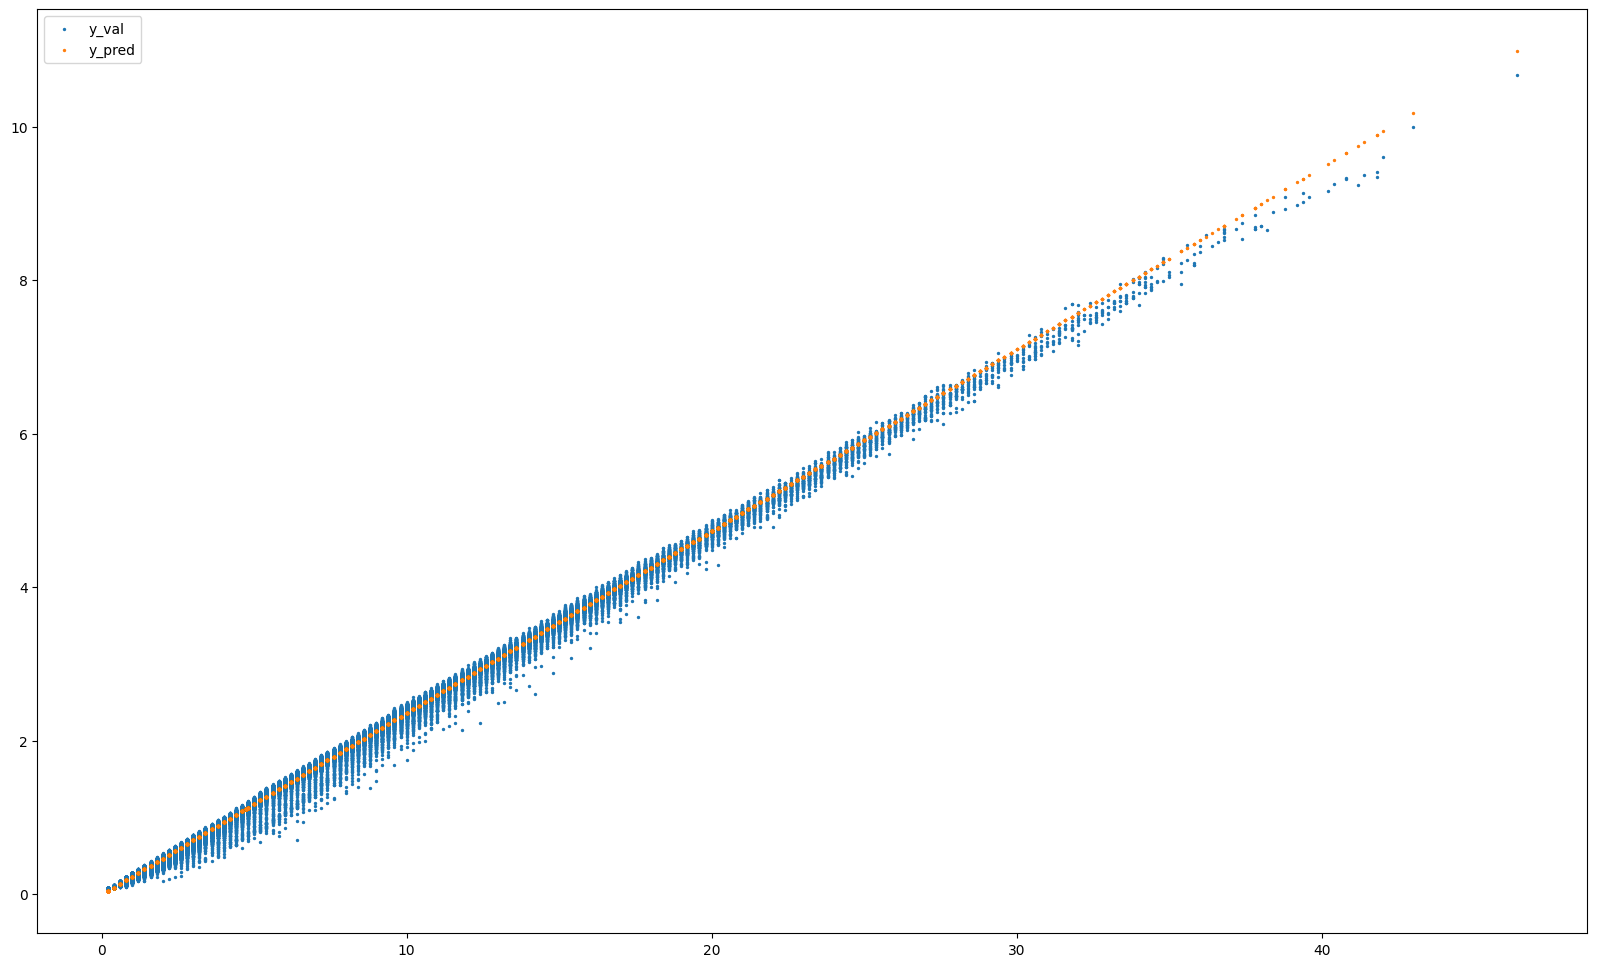

In [10]:
plt.figure(figsize=(20, 12))  

plt.scatter(x_val.T[0], y_val, label="y_val", s=2)       # Уменьшение размера точек для истинных значений на валидационной выборке 
                                                         # x_val.T[0] означает первый признак (первая колонка) в валидационной выборке
plt.scatter(x_val.T[0], y_val_pred, label="y_pred", s=2) # Уменьшение размера точек для предсказанных значений на валидационной выборке

plt.legend()   
plt.show()

4. Постройте модель, используя полиномиальную функцию. Постройте графики зависимости точности (r2_score) от степени полиномиальной функции для обучающего набора и тестового набора (кривая валидации).

Лучшее значение степени: 4. Лучшее значение r2: 0.9981812447661353


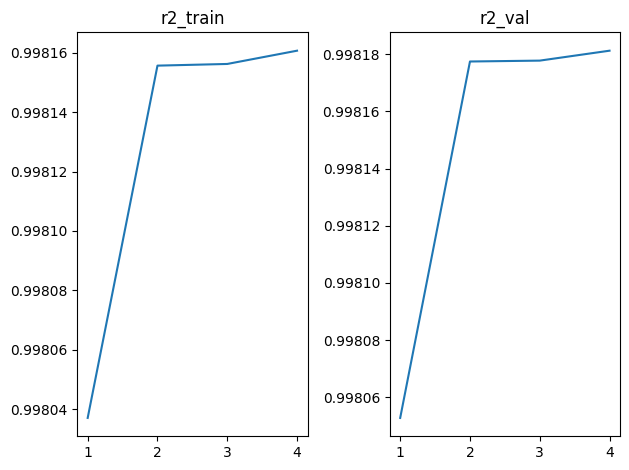

In [11]:
max_degree = 4              # Максимальная степень полинома, которую мы рассматриваем

# Инициализация списка для значений коэффициента детерминации на обучающей и валидационной выборке
r2_train = [0] * max_degree     
r2_val = [0] * max_degree

fig, axs = plt.subplots(1, 2)   # Создание графика с двумя подграфиками (1 строка, 2 столбца)

# Инициализация переменной для хранения лучшей степени полинома и значения коэффициента детерминации
best_degree = 1                 
best_r2_score = 0         

for id, polynomial_degree in enumerate(range(1, max_degree + 1)):   # Цикл по всем степеням полинома от 1 до max_degree
    polynomial_features  = PolynomialFeatures(degree=polynomial_degree, include_bias=False) # Создание объекта PolynomialFeatures с текущей степенью
    linear_regression = linear_model.LinearRegression()             # Создание объекта модели линейной регрессии

    pipeline = Pipeline(
        [
            ("polynomial_features", polynomial_features),           # Добавление преобразования полиномиальных признаков в конвейер
            ("linear_regression", linear_regression),               # Добавление линейной регрессии в конвейер
        ]
    )

    pipeline.fit(x_train, y_train) # Обучение модели на обучающих данных

    # Предсказание значений на обучающей и валидной выборках
    y_train_pred = pipeline.predict(x_train)
    y_val_pred = pipeline.predict(x_val)

    # Вычисление коэффициента детерминации на обучающей и валидационной выборках
    r2_train[id] = r2_score(y_train, y_train_pred)  
    r2_val[id] = r2_score(y_val, y_val_pred)

    if r2_val[id] >= best_r2_score:                 # Если текущее значение коэффициента детерминации на валидационной выборке лучше предыдущего лучшего
        best_r2_score = r2_val[id]                  # Обновляем лучшее значение коэффициента детерминации
        best_degree = polynomial_degree             # Обновляем лучшую степень полинома

print(f'Лучшее значение степени: {best_degree}. Лучшее значение r2: {best_r2_score}') 

axs[0].plot(np.linspace(1, max_degree, max_degree), r2_train) # Построение графика зависимости r2 на обучающей выборке от степени полинома
axs[0].set_title('r2_train')

axs[1].plot(np.linspace(1, max_degree, max_degree), r2_val)   # Построение графика зависимости r2 на валидационной выборке от степени полинома
axs[1].set_title('r2_val')

#plt.ylim(0.9, 1.2)    # Ограничение по оси y для лучшего визуального представления данных

fig.tight_layout()  # Автоматическое распределение подграфиков для лучшего визуального представления
plt.show()          

5) Создайте модель, используя регуляризацию. Выберите один из «Lasso» или «Ridge». На основе экспериментов подберите параметры для регуляризации. Постройте графики с зависимостью ошибки (r2_score) от коэффициента регуляризации для обучающего набора данных и набора тестовых данных (кривая проверки).

Лучшее значение параметра alpha: 1.0. Лучшее значение r2: 0.9981582051669815


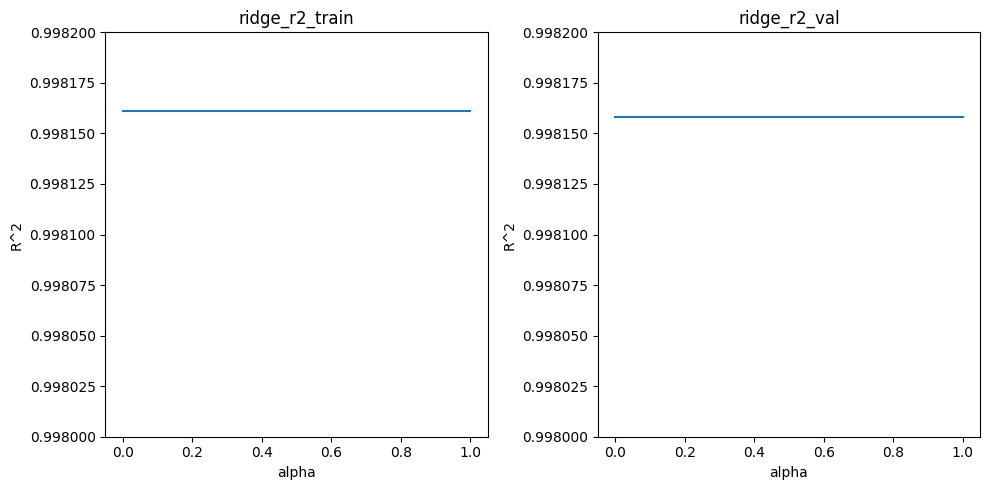

In [12]:
x_train, x_val, y_train, y_val = train_test_split(x_data_imputer, y_data_imputed, test_size=0.2)   # Разделение данных на обучающую и валидационную выборки

ridge_regression_degree = 3     # Степень полинома для Ridge регрессии
count_alpha = 10                # Количество значений параметра alpha, которые мы рассматриваем

# Инициализация списка для значений коэффициента детерминации на обучающей и валидационной выборке для Ridge регрессии
ridge_r2_train = [0] * count_alpha  
ridge_r2_val = [0] * count_alpha 

fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Создание графика с двумя подграфиками (1 строка, 2 столбца) и увеличенным размером

# Инициализация переменной для хранения лучшего значения параметра alpha и коэффициента детерминации
best_alpha = 0
best_r2_score = -1e10

# Цикл по всем значениям параметра alpha от 0 до 1
for id, alpha_factor in enumerate(np.linspace(0, 1, count_alpha)):  
    polynomial_features = PolynomialFeatures(degree=ridge_regression_degree, include_bias=False)  # Создание объекта PolynomialFeatures с текущей степенью (гребневая регрессия)

    ridge_regression = linear_model.Ridge(alpha=alpha_factor)  # Создание объекта Ridge регрессии с текущим значением параметра alpha

    # Класс Pipeline позволяет объединить несколько этапов обработки данных, таких как преобразование признаков, нормализация данных и моделирование
    pipeline = Pipeline(
        [
            ("polynomial_features", polynomial_features),   # Добавление преобразования полиномиальных признаков в конвейер
            ("ridge_regression", ridge_regression),         # Добавление Ridge регрессии в конвейер
        ]
    )

    pipeline.fit(x_train, y_train)  # Обучение модели на обучающих данных

    # Предсказание значений на обучающей и валидационной выборке
    y_train_pred = pipeline.predict(x_train)    
    y_val_pred = pipeline.predict(x_val) 

    # Вычисление коэффициента детерминации на обучающей и валидационной выборке для текущего значения alpha
    ridge_r2_train[id] = r2_score(y_train, y_train_pred)    
    ridge_r2_val[id] = r2_score(y_val, y_val_pred)

    if ridge_r2_val[id] > best_r2_score:  # Если текущее значение коэффициента детерминации на валидационной выборке лучше предыдущего лучшего
        best_r2_score = ridge_r2_val[id]  # Обновляем лучшее значение коэффициента детерминации и параметра alpha
        best_alpha = alpha_factor

print(f'Лучшее значение параметра alpha: {best_alpha}. Лучшее значение r2: {best_r2_score}')

# Построение графика зависимости r2 на обучающей выборке от параметра alpha
axs[0].plot(np.linspace(0, 1, count_alpha), ridge_r2_train)     
axs[0].set_title('ridge_r2_train')                            
axs[0].set_ylim(0.998, 0.99820)  # Ограничение по оси y для валидационной выборки
axs[0].set_xlabel('alpha')
axs[0].set_ylabel('R^2')

# Построение графика зависимости r2 на валидационной выборке от параметра alpha
axs[1].plot(np.linspace(0, 1, count_alpha), ridge_r2_val)       
axs[1].set_title('ridge_r2_val')                             
axs[1].set_ylim(0.998, 0.99820)  # Ограничение по оси y для валидационной выборки
axs[1].set_xlabel('alpha')
axs[1].set_ylabel('R^2')

fig.tight_layout()  # Автоматическое распределение подграфиков для лучшего визуального представления
plt.show()
